In [0]:
import os 
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision.models import resnet18
import torchvision.transforms as transforms
import tqdm
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd

In [0]:
class ImageNet(Dataset):
    def __init__(self, path_str):
        self.path = path_str
        self.folder_paths = glob("{}/*/".format(self.path))
        
        # since there are only two classes, we could hard code the label dic
        self.lbl_dic = {"n02123394": 1, "n02109961":0}
        # 1: cat   0: dog

        self.img_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

        self.imgs = []
        self.lbls = []
        for folder_path in self.folder_paths:
            image_paths = glob("{}/*".format(folder_path))
            self.imgs += image_paths
            self.lbls += [self.lbl_dic[folder_path.split("/")[-2]]] * len(image_paths)
    
    def __getitem__(self, index):
        img = Image.open(self.imgs[index]).convert("RGB")
        img = self.img_transforms(img)
        lbl = self.lbls[index]
        return img, lbl
    
    def __len__(self):
        return len(self.imgs)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.pretrained_resnet = resnet18(pretrained=False)
        self.resnet = nn.Sequential(*list(self.pretrained_resnet.children())[:-1])
        self.fc1 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = self.resnet(x)  #[batch_saize, 512, 1, 1]
        x = self.fc1(x.view(-1, 512))
        return x

In [0]:
train_dataset = ImageNet("/content/drive/My Drive/CV/imagenet_12/imagenet_12_train")
val_dataset = ImageNet("/content/drive/My Drive/CV/imagenet_12/imagenet_12_val")

torch.manual_seed(0)

BATCH_SIZE = 20
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
def evaluate_acc(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(dataloader):
            outs = model(imgs.to(device))
            _, temp_preds = torch.max(outs, 1)
            total += lbls.size(0)
            temp_preds = temp_preds.cpu()
            correct += (temp_preds == lbls).sum().item()
    return correct / total

In [0]:
def train_model(model):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    NUM_EPOCHS=50
    for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
        model.train() 
        for i, (imgs, lbls) in enumerate(train_loader):
            preds = model(imgs.to(device))
            loss = criterion(preds, lbls.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss_history.append(loss.item())
        cur_val_acc = evaluate_acc(model, val_loader)
        val_accuracy_history.append(cur_val_acc)

        model.eval()
        for i, (imgs, lbls) in enumerate(val_loader):
            preds = model(imgs.to(device))
            loss = criterion(preds, lbls.to(device))
            val_loss_history.append(loss.item())
    
    return train_loss_history, val_loss_history, val_accuracy_history

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("yes")
else:
    device=torch.device('cpu')

model1 = ResNet()
model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.1)
train_loss_history1, val_loss_history1, val_accuracy_history1 = train_model(model1)

yes


In [9]:
model2 = ResNet()
model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01)
train_loss_history2, val_loss_history2, val_accuracy_history2 = train_model(model2)

In [10]:
model3 = ResNet()
model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.001)
train_loss_history3, val_loss_history3, val_accuracy_history3 = train_model(model3)

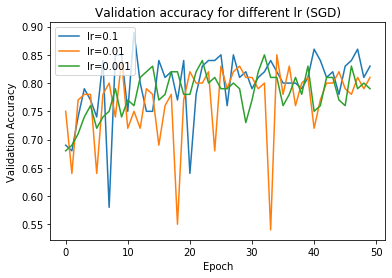

In [21]:
import matplotlib.pyplot as plt
import numpy as np

x1 = np.arange(len(val_accuracy_history1))
plt.plot(x1, val_accuracy_history1)
plt.plot(x1, val_accuracy_history2)
plt.plot(x1, val_accuracy_history3)
plt.title("Validation accuracy for different lr (SGD)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(['lr=0.1', 'lr=0.01', 'lr=0.001'], loc='upper left')
plt.show()

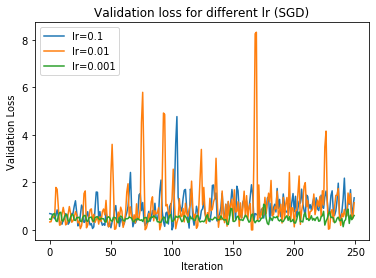

In [22]:
x2 = np.arange(len(val_loss_history1))
plt.plot(x2, val_loss_history1)
plt.plot(x2, val_loss_history2)
plt.plot(x2, val_loss_history3)
plt.title("Validation loss for different lr (SGD)")
plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.legend(['lr=0.1', 'lr=0.01', 'lr=0.001'], loc='upper left')
plt.show()

In [23]:
model4 = ResNet()
model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model4.parameters(), lr=0.1)
train_loss_history4, val_loss_history4, val_accuracy_history4 = train_model(model4)

In [24]:
model5 = ResNet()
model5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model5.parameters(), lr=0.01)
train_loss_history5, val_loss_history5, val_accuracy_history5 = train_model(model5)

In [25]:
model6 = ResNet()
model6.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model6.parameters(), lr=0.001)
train_loss_history6, val_loss_history6, val_accuracy_history6 = train_model(model6)

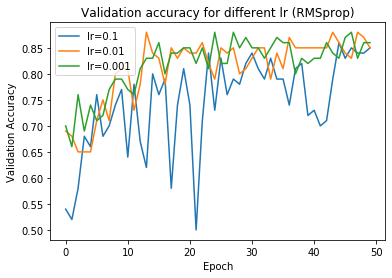

In [28]:
x3 = np.arange(len(val_accuracy_history4))
plt.plot(x3, val_accuracy_history4)
plt.plot(x3, val_accuracy_history5)
plt.plot(x3, val_accuracy_history6)
plt.title("Validation accuracy for different lr (RMSprop)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(['lr=0.1', 'lr=0.01', 'lr=0.001'], loc='upper left')
plt.show()

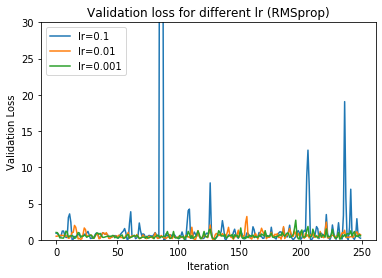

In [40]:
x4 = np.arange(len(val_loss_history4))
plt.plot(x4, val_loss_history4)
plt.plot(x4, val_loss_history5)
plt.plot(x4, val_loss_history6)
plt.title("Validation loss for different lr (RMSprop)")
plt.xlabel("Iteration")
plt.ylim(0, 30)
plt.ylabel("Validation Loss")
plt.legend(['lr=0.1', 'lr=0.01', 'lr=0.001'], loc='upper left')
plt.show()